# Defining Known Variables

In [11]:
import numpy as np
from scipy.linalg import expm
import pandas as pd
# Define Variables
u = 398600 # km^3/s^2
dt = 10 # s
x0 = 6678 # km
y0 = 0 # km
xd0 = 0 # km/s
yd0 = x0*(u/x0**3)**(1/2) # km/s
w = (2*np.pi)/86400 # rad/s
Re = 6378 # km


## Define Tracking Station Functions

In [2]:
def theta(i):
    return (i - 1)*(np.pi/6)

def xs(t, i):
    return Re*np.cos(w * t + theta(i))

def ys(t, i):
    return Re*np.sin(w * t + theta(i))

def xsd(t, i):
    return -Re*w*np.sin(w * t + theta(i))

def ysd(t, i):
    return Re*w*np.cos(w * t + theta(i))


## Define Jacobian Matrices and Evaluate at Initial Conditions

In [3]:
# Define Matrices

x = x0
y = y0
xd = xd0
yd = yd0
dx = xd
dy = yd

# A Matrix
# A = np.array([[0,1,0,0],
#               [-u*(y**2 - 2*x**2)/(y**2 + x**2)**(5/2),0,3*u*x*y/(y**2 + x**2)**(5/2),0],
#               [0,0,0,1],
#               [3*u*x*y/(y**2 + x**2)**(5/2),0,-u*(x**2 - 2*y**2)/(y**2 + x**2)**(5/2),0]])

A = np.array([[0,1,0,0],
              [3.0*u*x**2/(x**2 + y**2)**2.5 - u/(x**2 + y**2)**1.5,0,3.0*u*x*y/(x**2 + y**2)**2.5,0],
              [0,0,0,1],
              [3.0*u*x*y/(x**2 + y**2)**2.5,0,3.0*u*y**2/(x**2 + y**2)**2.5 - u/(x**2 + y**2)**1.5,0]])

# B Matrix
B = np.array([[0,0],
              [1,0],
              [0,0],
              [0,1]])


# C Matrix
C = []
for i in range(12):
    xs_i = xs(0, i)
    ys_i = ys(0, i)
    xsd_i = xsd(0, i)
    ysd_i = ysd(0, i)
    dxs = xsd_i
    dys = ysd_i

    # C_i = np.array([[(x-xs_i)/((x-xs_i)**2 + (y-ys_i)**2)**(1/2),0,(y-ys_i)/((x-xs_i)**2 + (y-ys_i)**2)**(1/2),0],
    #             [(y - ys_i)*((xd-xsd_i) * (y - ys_i) - (yd - ysd_i)*(x - xs_i))/((x - xs_i)**2 + (y - ys_i)**2)**(3/2),
    #             ((x-xs_i)**2)/((x - xs_i)**2 + (y - ys_i)**2)**(1/2),
    #             (x - xs_i)*((yd-ysd_i) * (x - xs_i) - (xd - xsd_i)*(y - ys_i))/((x - xs_i)**2 + (y - ys_i)**2)**(3/2),
    #             ((y-ys_i)**2)/((x - xs_i)**2 + (y - ys_i)**2)**(1/2)],
    #             [-1*(y-ys_i)/((x-xs_i)**2 + (y-ys_i)**2),0,(x-xs_i)/((x-xs_i)**2 + (y-ys_i)**2),0]])

    C_i = np.array([[(x-xs_i)/((x-xs_i)**2 + (y-ys_i)**2)**(1/2),0,(y-ys_i)/((x-xs_i)**2 + (y-ys_i)**2)**(1/2),0],
                [(dx - dxs)/((x - xs_i)**2 + (y - ys_i)**2)**0.5 + (-1.0*x + 1.0*xs_i)*((dx - dxs)*(x - xs_i) + (-dys + dy)*(y - ys_i))/((x - xs_i)**2 + (y - ys_i)**2)**1.5,
                (x - xs_i)/((x - xs_i)**2 + (y - ys_i)**2)**0.5,
                (-dys + dy)/((x - xs_i)**2 + (y - ys_i)**2)**0.5 + (-1.0*y + 1.0*ys_i)*((dx - dxs)*(x - xs_i) + (-dys + dy)*(y - ys_i))/((x - xs_i)**2 + (y - ys_i)**2)**1.5,
                (y - ys_i)/((x - xs_i)**2 + (y - ys_i)**2)**0.5],
                [-1*(y-ys_i)/((x-xs_i)**2 + (y-ys_i)**2),0,(x-xs_i)/((x-xs_i)**2 + (y-ys_i)**2),0]])

    C.append(C_i)

# D Matrix
D = np.array([[0,0],
              [0,0],
              [0,0]])

## Define Discrete Time Matrices

In [4]:
# Discrete time matrices
Ad = expm(A * dt)
Bd = np.linalg.inv(A) @ (Ad - np.eye(4)) @ B  # Only if A is invertible
Cd = C
Dd = D

In [5]:
print(Ad)
print(Bd)
print(Cd)
print(Dd)

[[ 1.00013385e+00  1.00004462e+01  0.00000000e+00  0.00000000e+00]
 [ 2.67699415e-05  1.00013385e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  9.99933079e-01  9.99977693e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.33840750e-05  9.99933079e-01]]
[[50.00111537  0.        ]
 [10.00044615  0.        ]
 [ 0.         49.99944232]
 [ 0.          9.99977693]]
[array([[ 3.40402514e-01,  0.00000000e+00,  9.40279814e-01,
         0.00000000e+00],
       [-7.51665622e-04,  3.40402514e-01,  2.72119920e-04,
         9.40279814e-01],
       [-2.77242436e-04,  0.00000000e+00,  1.00368019e-04,
         0.00000000e+00]]), array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.02420671,  0.        ],
       [-0.        ,  0.        ,  0.00333333,  0.        ]]), array([[ 3.40402514e-01,  0.00000000e+00, -9.40279814e-01,
         0.00000000e+00],
       [ 7.51665622e-04,  3.40402514e-01,  2.72119920e-04,
        -9.40279814e-01],
       [ 

## Simulation Loop (DT)

In [6]:
# Discrete Time Simulation
x_history = []
y_history = []

# Initial Conditions
x = np.array([[x0], [xd0], [y0], [yd0]])
x_history.append(x)
u = np.array([[0], [0]])

# Simulation Loop
for k in range(1400):
    y_temp = []
    x_k = Ad @ x + Bd @ u
    for i in range(12):
        # xs_i = xs(k-1, i)
        # ys_i = ys(k-1, i)
        # xsd_i = xsd(k-1, i)
        # ysd_i = ysd(k-1, i)

        # C_i = np.array([[(x-xs_i)/((x-xs_i)**2 + (y-ys_i)**2)**(1/2),0,(y-ys_i)/((x-xs_i)**2 + (y-ys_i)**2)**(1/2),0],
        #             [(y - ys_i)*((xd-xsd_i) * (y - ys_i) - (yd - ysd_i)*(x - xs_i))/((x - xs_i)**2 + (y - ys_i)**2)**(3/2),
        #             ((x-xs_i)**2)/((x - xs_i)**2 + (y - ys_i)**2)**(1/2),
        #             (x - xs_i)*((yd-ysd_i) * (x - xs_i) - (xd - xsd_i)*(y - ys_i))/((x - xs_i)**2 + (y - ys_i)**2)**(3/2),
        #             ((y-ys_i)**2)/((x - xs_i)**2 + (y - ys_i)**2)**(1/2)],
        #             [-1*(y-ys_i)/((x-xs_i)**2 + (y-ys_i)**2),0,(x-xs_i)/((x-xs_i)**2 + (y-ys_i)**2),0]])
        y_temp.append(Cd[i] @ x + Dd @ u)
        #y_temp.append(C_i @ x + Dd @ u)
    #y_k = Cd @ x + Dd @ u
    x_history.append(x_k)
    y_history.append(y_temp)
    x = x_k


In [7]:
X_array = pd.DataFrame(np.array(x_history)[:,0], columns=['X Position'])    
Xd_array = pd.DataFrame(np.array(x_history)[:,1], columns=['X Velocity'])
Y_array = pd.DataFrame(np.array(x_history)[:,2], columns=['Y Position'])
Yd_array = pd.DataFrame(np.array(x_history)[:,3], columns=['Y Velocity'])
rho_array = pd.DataFrame(np.array(y_history)[:,:,0].squeeze(), columns=['rho 1', 'rho 2', 'rho 3', 'rho 4', 'rho 5', 'rho 6', 'rho 7', 'rho 8', 'rho 9', 'rho 10', 'rho 11', 'rho 12'])
rhod_array = pd.DataFrame(np.array(y_history)[:,:,1].squeeze(), columns=['rhod 1', 'rhod 2', 'rhod 3', 'rhod 4', 'rhod 5', 'rhod 6', 'rhod 7', 'rhod 8', 'rhod 9', 'rhod 10', 'rhod 11', 'rhod 12'])
phi_array = pd.DataFrame(np.array(y_history)[:,:,2].squeeze(), columns=['phi 1', 'phi 2', 'phi 3', 'phi 4', 'phi 5', 'phi 6', 'phi 7', 'phi 8', 'phi 9', 'phi 10', 'phi 11', 'phi 12'])

In [8]:
import plotly.express as px

# Create figure with secondary y-axis
fig = px.line(X_array, y="X Position", title="X Position vs Time", range_x=[0,1400])
fig.show()

fig = px.line(Xd_array, y="X Velocity", title="X Velocity vs Time", range_x=[0,1400])
fig.show()

fig = px.line(Y_array, y="Y Position", title="Y Position vs Time", range_x=[0,1400])
fig.show()

fig = px.line(Yd_array, y="Y Velocity", title="Y Velocity vs Time", range_x=[0,1400])
fig.show()

fig = px.line(rho_array, y=["rho 1", "rho 2", "rho 3", "rho 4", "rho 5", "rho 6", "rho 7", "rho 8", "rho 9", "rho 10", "rho 11", "rho 12"], title="rho vs Time", range_x=[0,1400])
fig.show()

fig = px.line(rhod_array, y=["rhod 1", "rhod 2", "rhod 3", "rhod 4", "rhod 5", "rhod 6", "rhod 7", "rhod 8", "rhod 9", "rhod 10", "rhod 11", "rhod 12"], title="rhod vs Time", range_x=[0,1400])
fig.show()

fig = px.line(phi_array, y=["phi 1", "phi 2", "phi 3", "phi 4", "phi 5", "phi 6", "phi 7", "phi 8", "phi 9", "phi 10", "phi 11", "phi 12"], title="phi vs Time", range_x=[0,1400])
fig.show()



# Checking Derivations

In [21]:
from sympy import *
# Derive the equations
x, dx, y, dy, xs, dxs, ys, dys = symbols('x dx y dy xs dxs ys dys')
f = ((x - xs)*(dx - dxs) + (y - ys)*(dy - dys))/((x - xs)**2 + (y - ys)**2)**(1/2)
f_wrx = diff(f, x)
f_wry = diff(f, y)
f_wrdx = diff(f, dx)
f_wrdy = diff(f, dy)


In [22]:
print(f_wrx)
print(f_wry)
print(f_wrdx)
print(f_wrdy)

(dx - dxs)/((x - xs)**2 + (y - ys)**2)**0.5 + (-1.0*x + 1.0*xs)*((dx - dxs)*(x - xs) + (dy - dys)*(y - ys))/((x - xs)**2 + (y - ys)**2)**1.5
(dy - dys)/((x - xs)**2 + (y - ys)**2)**0.5 + (-1.0*y + 1.0*ys)*((dx - dxs)*(x - xs) + (dy - dys)*(y - ys))/((x - xs)**2 + (y - ys)**2)**1.5
(x - xs)/((x - xs)**2 + (y - ys)**2)**0.5
(y - ys)/((x - xs)**2 + (y - ys)**2)**0.5


In [25]:
x, dx, ddx, y, dy, ddy, u1, w1, u2, w2, u = symbols('x dx ddx y dy ddy u1 w1 u2 w2 u')
ddx = (-1*u*x)/((x**2 + y**2)**(1/2))**3 + u1 + w1
ddy = (-1*u*y)/((x**2 + y**2)**(1/2))**3 + u2 + w2
ddx_wrx = diff(ddx, x)
ddx_wry = diff(ddx, y)
ddy_wrx = diff(ddy, x)
ddy_wry = diff(ddy, y)
print(ddx_wrx)
print(ddx_wry)
print(ddy_wrx)
print(ddy_wry)

3.0*u*x**2/(x**2 + y**2)**2.5 - u/(x**2 + y**2)**1.5
3.0*u*x*y/(x**2 + y**2)**2.5
3.0*u*x*y/(x**2 + y**2)**2.5
3.0*u*y**2/(x**2 + y**2)**2.5 - u/(x**2 + y**2)**1.5


# ODE 45 Solution

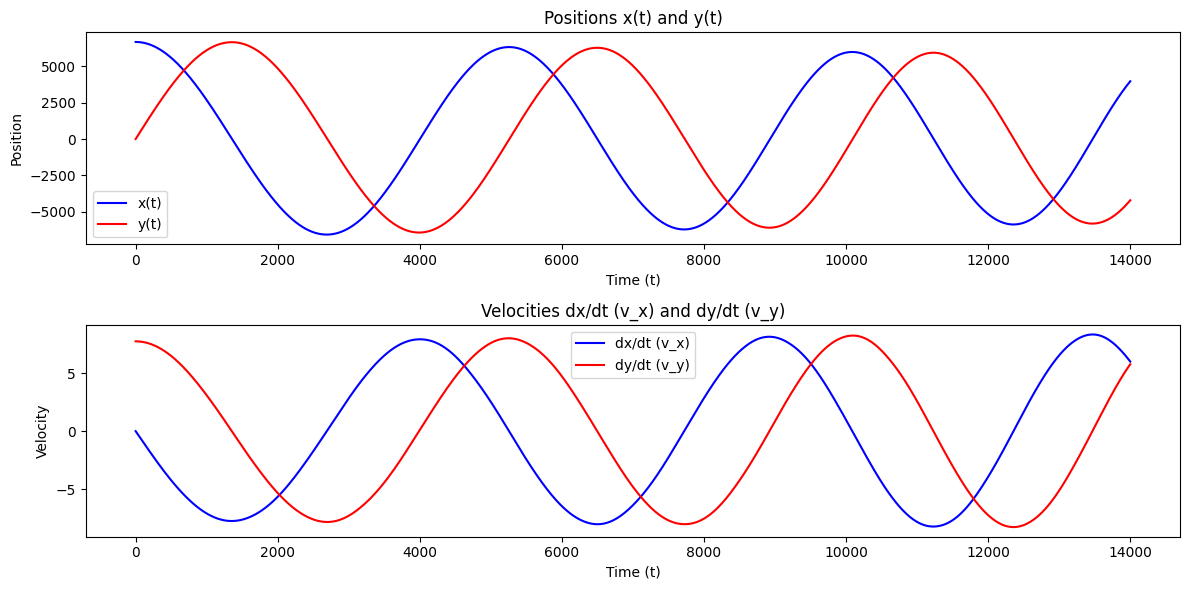

In [16]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters
u = 398600     # Constant parameter u
u1 = 0    # Constant parameter u1
u2 = 0     # Constant parameter u2
w1 = 0     # Constant parameter w1
w2 = 0     # Constant parameter w2

# Define the system of first-order ODEs
def system(t, state):
    x, v_x, y, v_y = state
    
    # Compute the derivatives
    dx_dt = v_x
    dvx_dt = (-u * x) / (x**2 + y**2)**(3/2) + u1 + w1
    dy_dt = v_y
    dvy_dt = (-u * y) / (x**2 + y**2)**(3/2) + u2 + w2
    
    return [dx_dt, dvx_dt, dy_dt, dvy_dt]

# Initial conditions: x(0), dx(0), y(0), dy(0)
initial_conditions = [6678, 0.0, 0.0, 7.725835197559566]  # For example, starting at x=1, y=0, with zero velocity

# Time span for the solution
t_span = (0, 14000)  # From t=0 to t=10
t_eval = np.linspace(0, 14000, 14000)  # Times at which we want the solution

# Solve the system using solve_ivp
solution = solve_ivp(system, t_span, initial_conditions, t_eval=t_eval)

# Extract the results from the solution
x_vals = solution.y[0]
v_x_vals = solution.y[1]
y_vals = solution.y[2]
v_y_vals = solution.y[3]

# Plot the results
plt.figure(figsize=(12, 6))

# Plot x and y over time
plt.subplot(2, 1, 1)
plt.plot(solution.t, x_vals, label='x(t)', color='b')
plt.plot(solution.t, y_vals, label='y(t)', color='r')
plt.xlabel('Time (t)')
plt.ylabel('Position')
plt.legend()
plt.title('Positions x(t) and y(t)')

# Plot the velocities v_x and v_y over time
plt.subplot(2, 1, 2)
plt.plot(solution.t, v_x_vals, label='dx/dt (v_x)', color='b')
plt.plot(solution.t, v_y_vals, label='dy/dt (v_y)', color='r')
plt.xlabel('Time (t)')
plt.ylabel('Velocity')
plt.legend()
plt.title('Velocities dx/dt (v_x) and dy/dt (v_y)')

plt.tight_layout()
plt.show()
